In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob


In [26]:
val_images = sorted(glob.glob("*.nii"))
val_labels = sorted(glob.glob("*.nii"))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]
val_files=data_dicts
print(val_files)

[{'image': 'volume-63.nii', 'label': 'volume-63.nii'}]


In [27]:
set_determinism(seed=0)

In [28]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [9]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
model.load_state_dict(torch.load("model.pt"))
model.eval()
dice_metric = DiceMetric(include_background=False, reduction="mean")

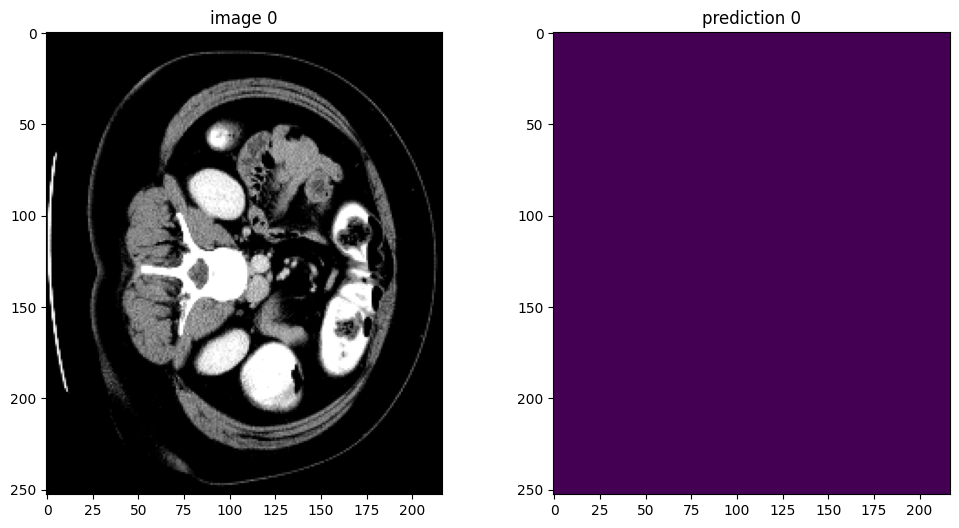

In [29]:
import numpy as np
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot a slice
        slice=140
        plt.figure("check", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, slice], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title(f"prediction {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice])
        plt.show()
        if i == 2: # plot up to 3 slices
            break

In [46]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)
val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        # AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        # AsDiscreted(keys="label", to_onehot=2),
    ]
)

volume-63.nii torch.Size([512, 512, 104])
torch.Size([512, 512, 104])


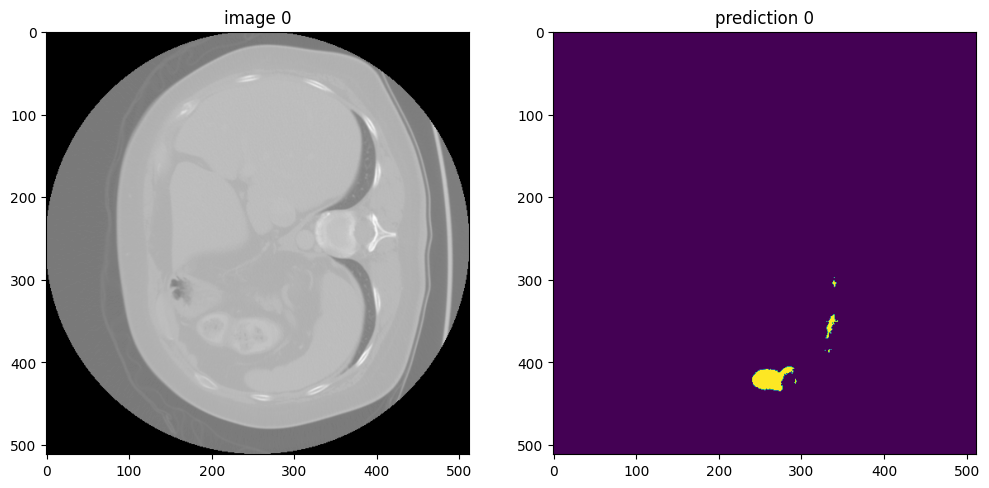

In [47]:
from monai.transforms import LoadImage
model.load_state_dict(torch.load("model.pt"))
model.eval()

with torch.no_grad():
    for j,val_data in enumerate(val_org_loader):
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_data[0]["image"]=LoadImage()(val_files[j]["image"])[0]
        #volume name and shape
        print(val_files[j]["image"],val_data[0]["image"].shape)
        # plot a slice
        if j==0:
            slice=80 #slice of first volume
        elif j==1:
            slice=130 #slice of second volume
        plt.figure("check", (12, 6))
        plt.subplot(1, 2, 1)
        # plt.axis('off')
        plt.title(f"image {j}")
        plt.imshow(val_data[0]["image"][:, :, slice], cmap="gray")
        # plt.colorbar()
        plt.subplot(1, 2, 2)
        # plt.axis('off')
        plt.title(f"prediction {j}")
        print(torch.argmax(val_data[0]["pred"], dim=0).shape)
        plt.imshow(torch.argmax(val_data[0]["pred"], dim=0).detach().cpu()[:, :, slice])
        plt.show()